# cml1 - Immobilienrechner
# 2.1 Einfache lineare Regression und Residuenanalyse

Verwende ein einfaches lineares Modell zur Vorhersage von `price_cleaned` mit dem Attribut `Space extracted` oder `Floor_space_merged` (es gibt einige, wo beide fehlen (um die 800, können ignoriert werden).

Entwickle das Modell in einem Notebook. Untersuche dabei ob die Annahmen eines linearen Modells erfüllt sind mit geeigneten Darstellungen. Wie können Variablen-Transformationen verwendet werden, um die Modellvoraussetzungen besser zu erfüllen und das Modell zu verbessern?

Rapportiere und diskutiere die erreichte Genauigkeit der Vorhersage mit mehreren sinnvollen Metriken und auf unabhängigen Testdaten.

Wir haben im Notebook "datawrangling.ipynb" den Datensatz bereinigt und lesen dieser hier ein. Die Aufgabe dieses Notebooks ist es, ein einfaches lineares Modell zu erstellen, um Vorhersagen von `price_cleaned` mit dem Attribut `Space extracted` oder `Floor_space_merged` zu machen. In unserem Fall ist der Attribut `Living_area_unified`, da wir alle "Nutzfläche" Variablen zusammengefasst haben.

**Achtung:** Im Datawrangling Notebook haben wir Space extracted zu `Living_area_unified` zusammengefasst. Anstelle hier also wie in der Aufgabenstellung `Space extraced` zu wählen, arbeiten wir mit `Living_area_unified`.

## Bibliotheken importieren

In [156]:
# General imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import itertools

# Models
from sklearn.linear_model import LinearRegression

# Model selection
from sklearn.model_selection import train_test_split

# Imputer
from sklearn.impute import SimpleImputer

# Metrics
from sklearn.metrics import mean_squared_error, r2_score

# Preprocessing
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import pickle

## Daten einlesen

In [157]:
df = pd.read_csv('../../../data/immo_data_clean.csv', low_memory=False)
print(df.shape)

(21466, 57)


## Vorbereitungen

In diesem Abschnitt untersuchen wir die gefragten Variablen und machen uns Gedanken über die Modellvoraussetzungen.

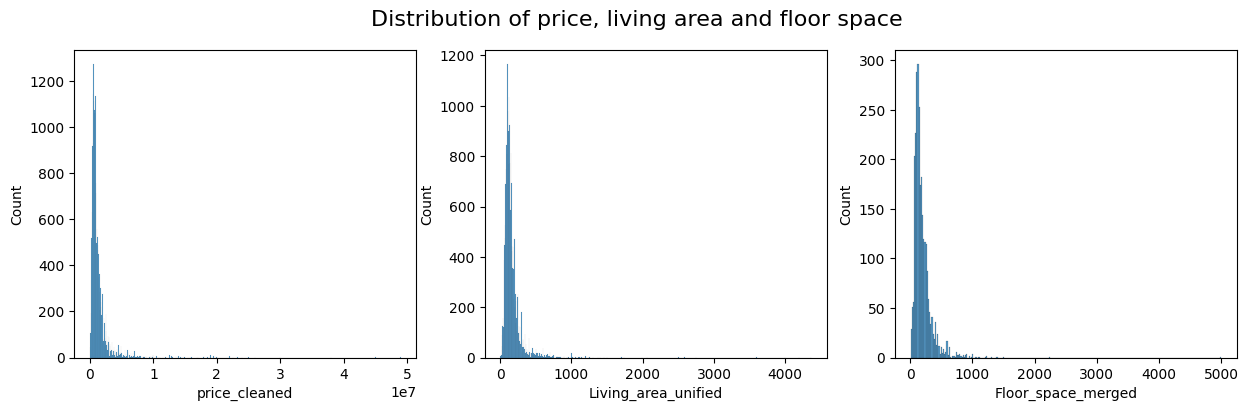

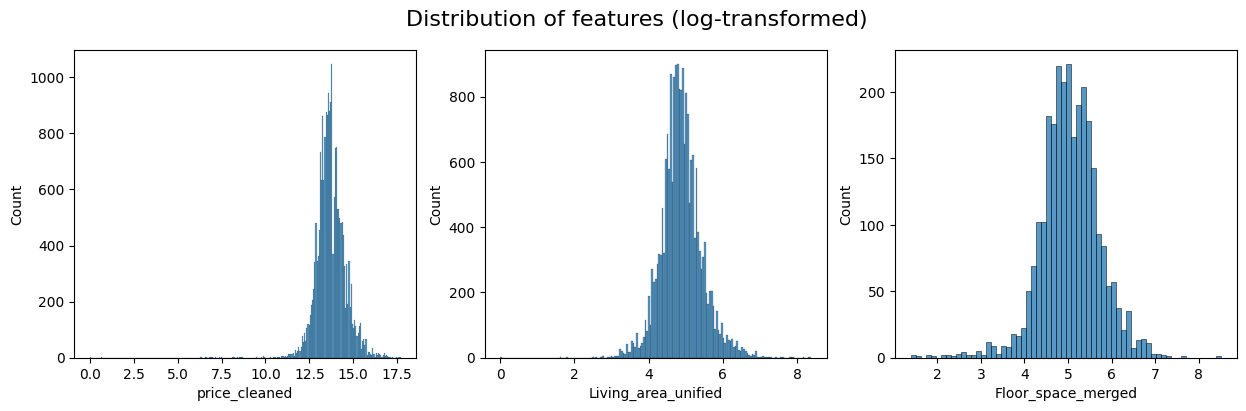

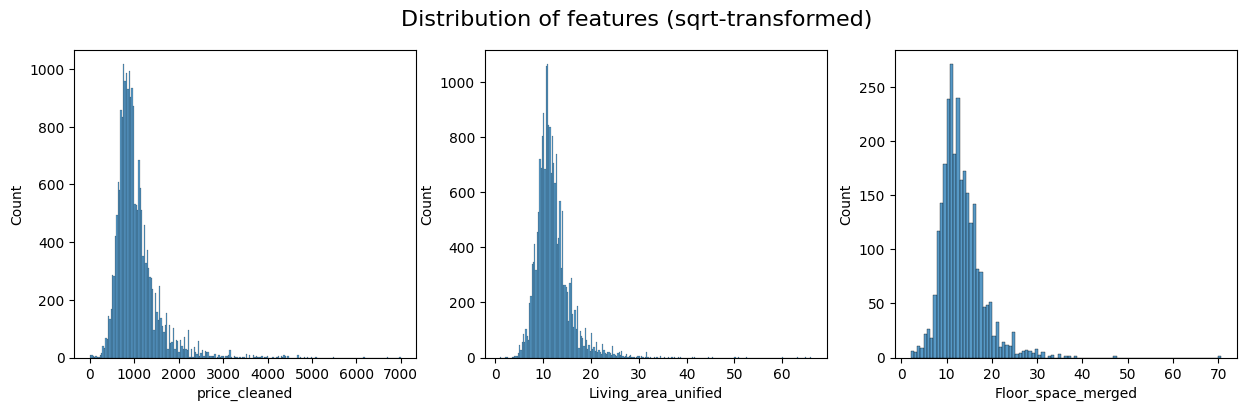

In [158]:
def plot_distributions(var1, var2, var3, title):
    fig, ax = plt.subplots(1, 3, figsize=(15, 4))
    fig.suptitle(title, fontsize=16)
    sns.histplot(var1, ax=ax[0])
    sns.histplot(var2, ax=ax[1])
    sns.histplot(var3, ax=ax[2])
    plt.show()
    
plot_distributions(
    df['price_cleaned'], 
    df['Living_area_unified'], 
    df['Floor_space_merged'], 
    'Distribution of price, living area and floor space'
)

plot_distributions(
    np.log(df['price_cleaned']),
    np.log(df['Living_area_unified']),
    np.log(df['Floor_space_merged']),
    'Distribution of features (log-transformed)'
)

plot_distributions(
    np.sqrt(df['price_cleaned']),
    np.sqrt(df['Living_area_unified']),
    np.sqrt(df['Floor_space_merged']),
    'Distribution of features (sqrt-transformed)'
)

Anhand der Verteilungen ohne Transformationen, sehen wir das die Verteilungen nicht normalverteilt sind, sondern linksschief. Bei einer linearen Regression kann eine linksschiefe Verteilung problematisch sein, da sie oft die Normalverteilungsannahme der Residuen verletzt, was die Genauigkeit und Validität der Modellschätzungen beeinträchtigt. Solche Verteilungen können auch zu einem überproportionalen Einfluss von Ausreissern führen. Um diese Probleme zu beheben, werden häufig Transformationen der Daten eingesetzt, um eine symmetrischere Verteilung zu erreichen und die Modellannahmen zu erfüllen. 

Wenn wir also die transformierten Verteilungen anschauen, sehen wir genauere Normalverteilungen. Es sind aber trotzdem viele Ausreisser vorhanden.

Schauen wir nun die fehlenden Werte unserer Variablen an.

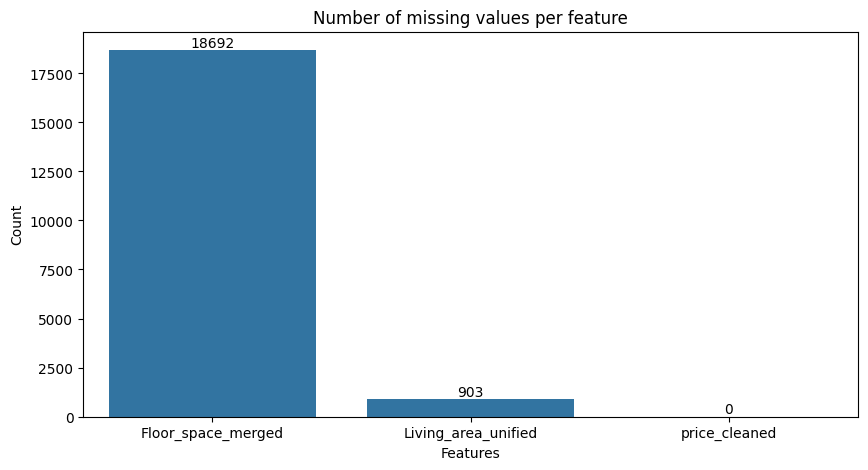

In [159]:
df_na = df[['price_cleaned', 'Living_area_unified', 'Floor_space_merged']].isnull().sum().sort_values(ascending=False)

plt.figure(figsize=(10, 5))
sns.barplot(x=df_na.index, y=df_na.values)
for i, v in enumerate(df_na.values):
    plt.text(i, v, str(v), ha='center', va='bottom')
plt.title('Number of missing values per feature')
plt.xlabel('Features')
plt.ylabel('Count')
plt.show()

Der Output von oben Zeigt uns: `Floor_space_merged` hat extrem viele fehlende Werte. Eine "einfache" lineare Regression würde hier nicht gut funktionieren.

In [160]:
# check where both columns are missing
df[(df['Living_area_unified'].isnull()) & (df['Floor_space_merged'].isnull())].shape

(711, 57)

Dieser Ouput von 711 Zeilen zeigt die in der Aufgabenstellung angekündigten ca. 800 Fehlenden Werte beider Features.

In [161]:
# drop rows where both columns are missing
df = df.dropna(subset=['Living_area_unified', 'Floor_space_merged'], how='all')
df[(df['Living_area_unified'].isnull()) & (df['Floor_space_merged'].isnull())].shape

(0, 57)

Wie in der Aufgabenstellung beschrieben werden diese 711 Zeilen nun für unsere Modelle ignoriert.

In [162]:
df_211 = df.copy()
df_212 = df.copy()
df_213 = df.copy()
df_214 = df.copy()

Wir haben nun folgende Optionen für die Modellierung:

- Wir verwenden nur `Living_area_unified` und rechnen unser Modell so - (2.1.1)
- Wir ersetzen fehlende `Floor_space_merged` values mit `Living_area_unified` - (2.1.2)
- Wir ersetzen fehlende `Living_area_unified` values mit `Floor_space_merged` - (2.1.3)
- Wir versuchen anhand der beiden Features ein neues Feature zu generieren das anstelle `Floor_space_merged` verwendet wird. - (2.1.4)
- Wir verwenden ein nicht lineares Modell, welches dann aber nicht mehr der Aufgabenstellung für 2.1 entspricht

## 2.1.1 Einfache lineare Regression und Residuenanalyse

In dieser Teilaufgabe wird eine einfache lineare Regression mit `Living_area_unified` als Feature und `price_cleaned` als Target Variable erstellt. Wir werden die Annahmen eines linearen Modells mit geeigneten Darstellungen untersuchen und Variablen-Transformationen verwenden, um die Modellvoraussetzungen eventuell besser zu erfüllen und das Modell zu verbessern.

In [163]:
# Subset dataset
df_211 = df_211[['Living_area_unified', 'price_cleaned']]

# Drop na values
df_211 = df_211.dropna(subset=['Living_area_unified'])

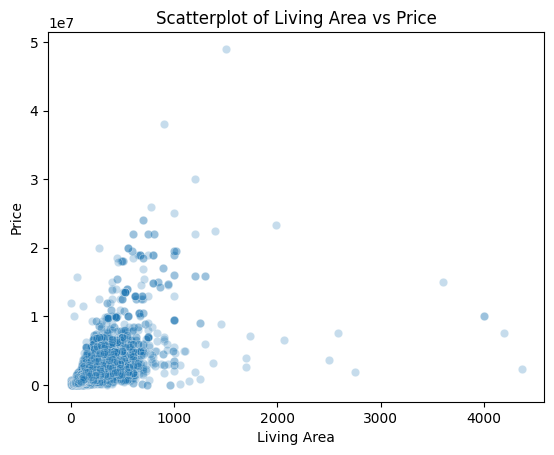

In [164]:
# Split dataset
X = df_211['Living_area_unified']
y = df_211['price_cleaned']

sns.scatterplot(data=df_211, x=X, y=y, alpha=0.25)
plt.title('Scatterplot of Living Area vs Price')
plt.ylabel('Price')
plt.xlabel('Living Area')
plt.show()

Anhand des Scatterplots sehen wir keine grosse Korrelaiton zwischen dem Preis und der Nutzfläche. Wir werden trotzdem eine lineare Regression durchführen, um die Residuen zu analysieren.

Erstellen wir nun eine Funktion, bei der wir verschiedene Modelle erstellen können. Die Funktion wird folgendermassen gestaltet:

Eingabe:
1. $X$ (Feature-Daten)
2. $y$ (Zielvariable)
3. Eine Transformationsfunktion (optional), die auf $X$ angewendet wird, bevor die Regression durchgeführt wird.

Ausgabe:
1. Ein Plot mit drei Subplots: "Actual vs Predicted Price", "Residuals" und "Residuals Histogram".

In [165]:
def perform_linear_regression(X, y, x_transformation_func=None, y_transformation_func=None, plot=True, title=""):
    """
    Performs a linear regression on the given data. 
    If provided, applies the given transformation functions to the data and plots the results.
    """

    # Apply transformation if provided
    if x_transformation_func:
        X = x_transformation_func(X)

    if y_transformation_func:
        y = y_transformation_func(y)
    
    # Split dataset
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Train linear regression model
    lin_reg = LinearRegression()

    if len(X_train.shape) == 1:
        lin_reg.fit(X_train.values.reshape(-1, 1), y_train)
        y_pred = lin_reg.predict(X_test.values.reshape(-1, 1))
    else:
        lin_reg.fit(X_train, y_train)
        y_pred = lin_reg.predict(X_test)

    # Transform back to original scale
    if y_transformation_func and y_transformation_func.__name__ == 'log':
        y_pred = np.exp(y_pred)
        y_test = np.exp(y_test)
    elif y_transformation_func and y_transformation_func.__name__ == 'sqrt':
        y_pred = np.square(y_pred)
        y_test = np.square(y_test)
    elif y_transformation_func and y_transformation_func.__name__ == 'square':
        y_pred = np.sqrt(y_pred)
        y_test = np.sqrt(y_test)

    r2 = round(r2_score(y_test, y_pred),4)
    mse = mean_squared_error(y_test, y_pred)
    mse_sqrt = round(np.sqrt(mse),2)
    mae = round(np.mean(np.abs(y_test - y_pred)),2)

    if plot:
    
        fig, ax = plt.subplots(1, 3, figsize=(15, 5))

        fig.suptitle(f'Living Area vs Price - {title}', fontsize=16)
        
        # Actual vs Predicted plot
        sns.regplot(x=y_test, y=y_pred, scatter_kws={'alpha': 0.1}, ax=ax[0])
        ax[0].set_title('Actual vs Predicted')
        ax[0].set_xlabel('Actual Price')
        ax[0].set_ylabel('Predicted Price')

        # Residuals plot
        sns.residplot(x=y_test, y=y_pred, scatter_kws={'alpha': 0.1}, ax=ax[1])
        ax[1].set_title('Residuals')
        ax[1].set_xlabel('Actual Price')
        ax[1].set_ylabel('Residuals')

        # Histogram plot
        sns.histplot((y_test - y_pred), ax=ax[2])
        ax[2].set_title('Residuals Histogram')
        ax[2].set_xlabel('Residuals')
        ax[2].set_ylabel('Frequency')
        
        plt.show()

    else:
        print(title)

    print(f'R2: {r2:.4f} - RMSE: {mse_sqrt:.4f}, MAE: {mae:.4f}\n')

In [166]:
def train_linear_regression(X, y, x_transformation_func=None, y_transformation_func=None):
    """
    Trains a linear regression on the given data. 
    returns the model (used to store in a pickle file)
    """

    # Apply transformation if provided
    if x_transformation_func:
        X = x_transformation_func(X)

    if y_transformation_func:
        y = y_transformation_func(y)
    
    # Split dataset
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Train linear regression model
    lin_reg = LinearRegression()

    if len(X_train.shape) == 1:
        lin_reg.fit(X_train.values.reshape(-1, 1), y_train)
        y_pred = lin_reg.predict(X_test.values.reshape(-1, 1))
    else:
        lin_reg.fit(X_train, y_train)
        y_pred = lin_reg.predict(X_test)
    return lin_reg

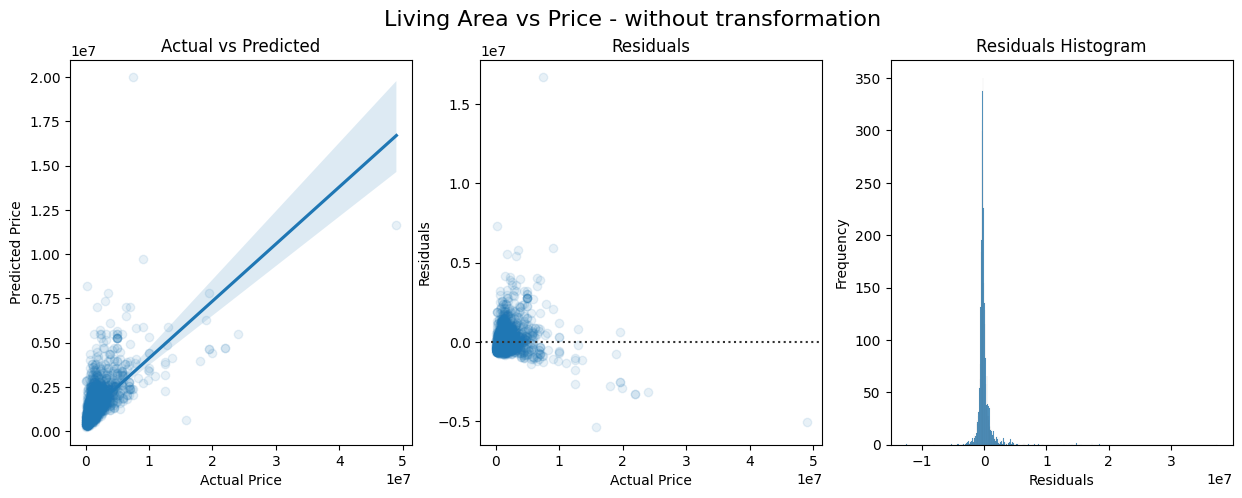

R2: 0.3932 - RMSE: 1339575.9200, MAE: 570184.6900



In [167]:
perform_linear_regression(X, y, None, None, True, "without transformation")

Es ist gut zu sehen, dass das Modell die Immobilienpreise nicht gut vorhersagen kann.
- $R^2$ ist sehr klein: 39.32%
- Die Residuen streuen sich nicht um den Erwartungswert 0.
- Die Residuen sind recht normalverteilt, aber es gibt grosse Ausreisser.

Um das Modell eventuell zu verbessern, werden wir folgende Variablen-Transformation machen:
- Log
- Quadrat
- Quadratwurzel

### Log-Transformation (2.1.1)

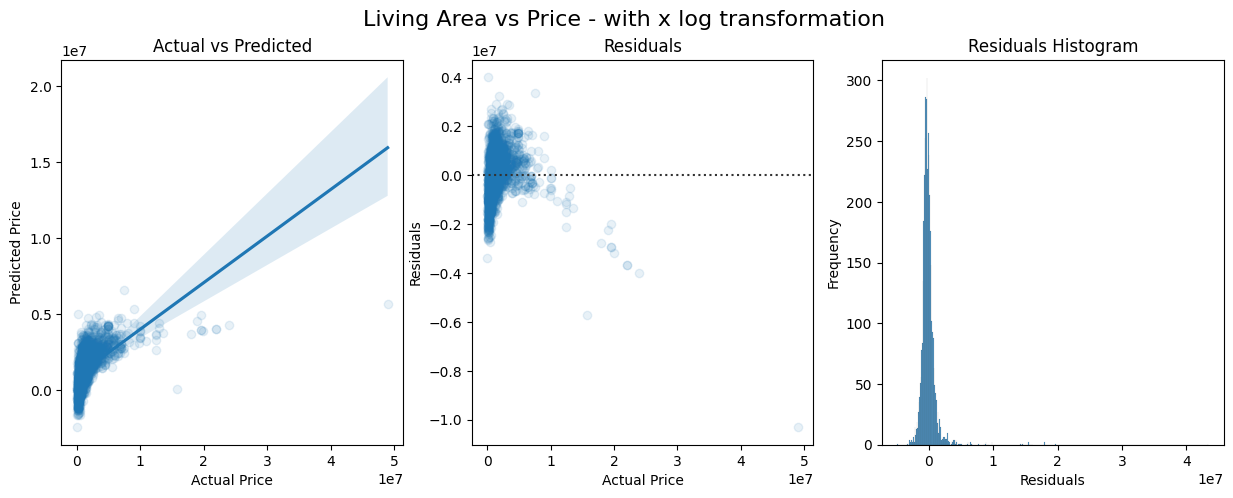

R2: 0.3048 - RMSE: 1433837.9500, MAE: 682242.5100



In [168]:
perform_linear_regression(X, y, np.log, None, True, "with x log transformation")

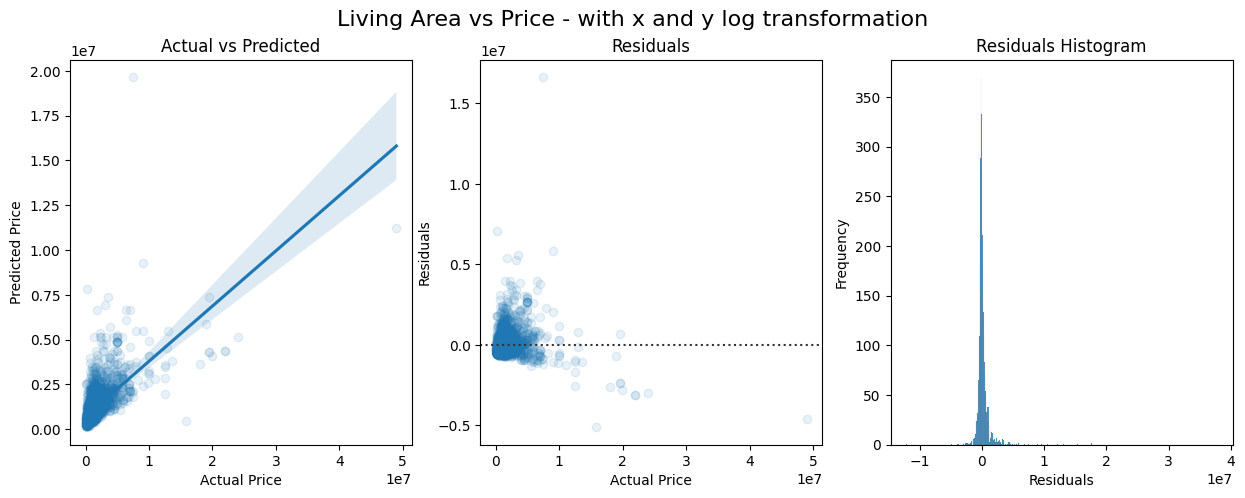

R2: 0.3744 - RMSE: 1360145.3700, MAE: 524850.1700



In [169]:
perform_linear_regression(X, y, np.log, np.log, True, "with x and y log transformation")

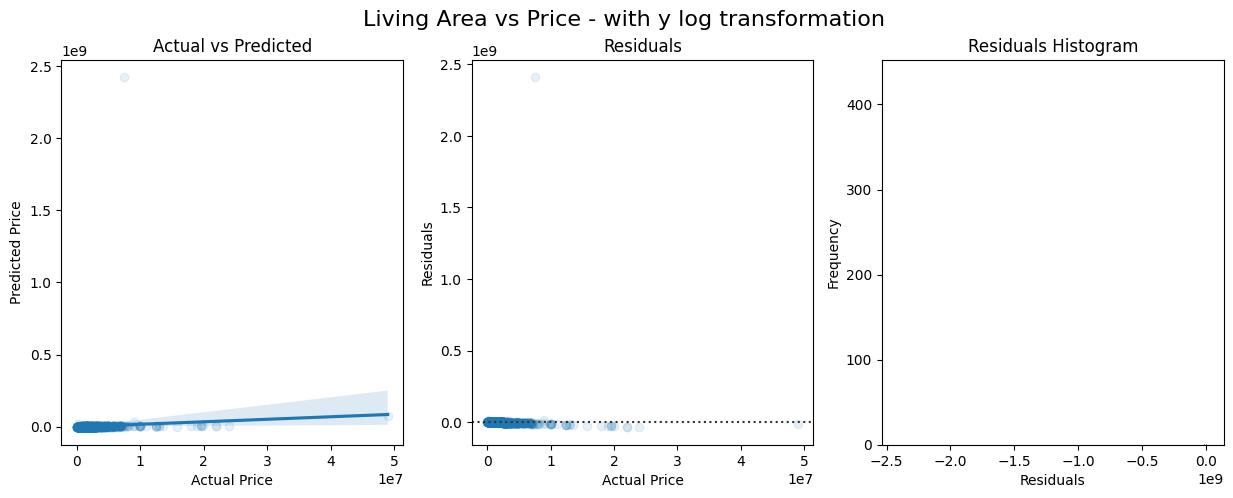

R2: -479.3267 - RMSE: 37687635.3900, MAE: 1177128.4100



In [170]:
perform_linear_regression(X, y, None, np.log, True, "with y log transformation")

Bei der Log-Transformation der x- und y-Variablen sehen wir eine minimale Verbesserung des Modells im Sinne des Mean Average Error (MAE). Im Sinne der anderen Metriken ist das Modell etwas schlechter geworden.

### Quadrat-Transformation (2.1.1)

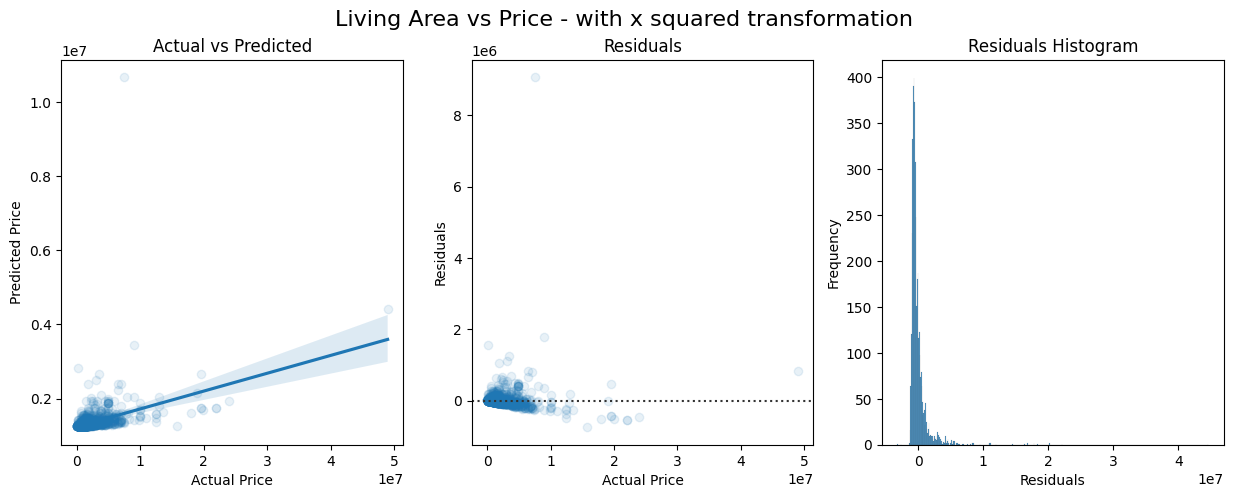

R2: 0.0846 - RMSE: 1645302.8500, MAE: 795996.3500



In [171]:
perform_linear_regression(X, y, np.square, None, plot=True, title="with x squared transformation")

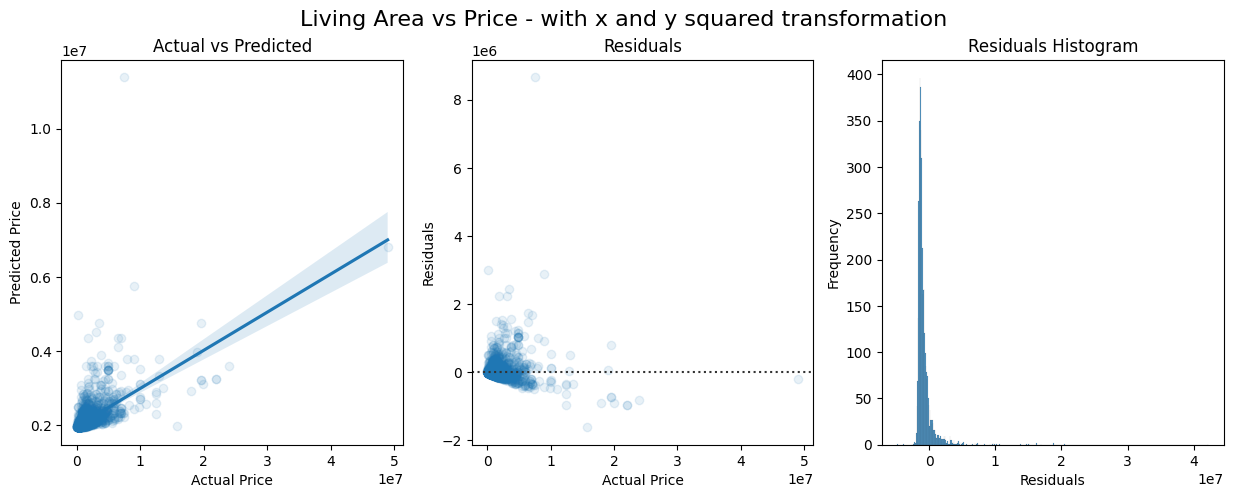

R2: -0.0416 - RMSE: 1754975.5600, MAE: 1246092.5000



In [172]:
perform_linear_regression(X, y, np.square, np.square, True, "with x and y squared transformation")

### Quadratwurzel-Transformation (2.1.1)

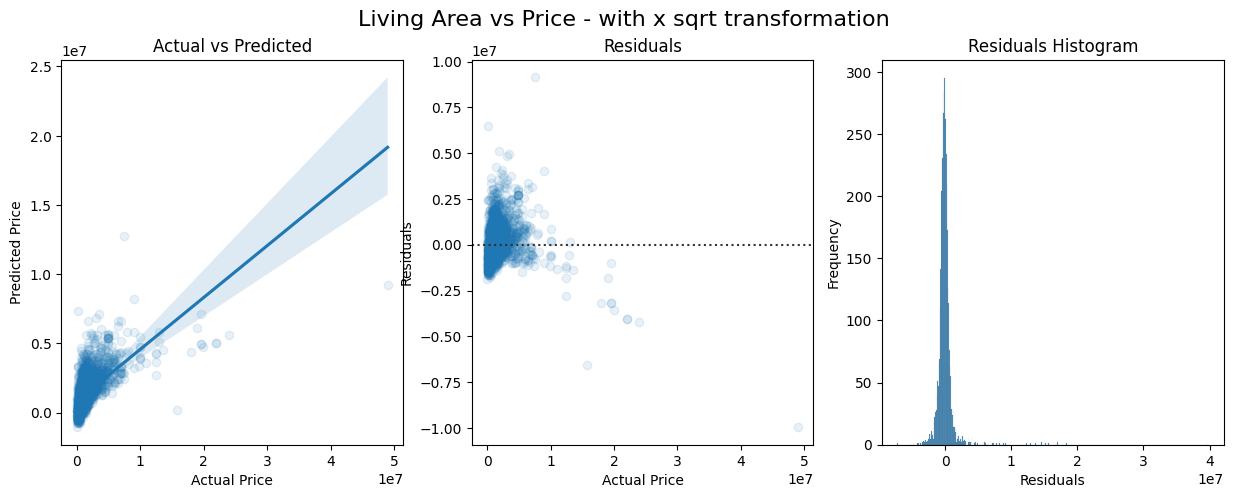

R2: 0.3815 - RMSE: 1352438.9000, MAE: 621362.0100



In [173]:
perform_linear_regression(X, y, np.sqrt, None, True, "with x sqrt transformation")

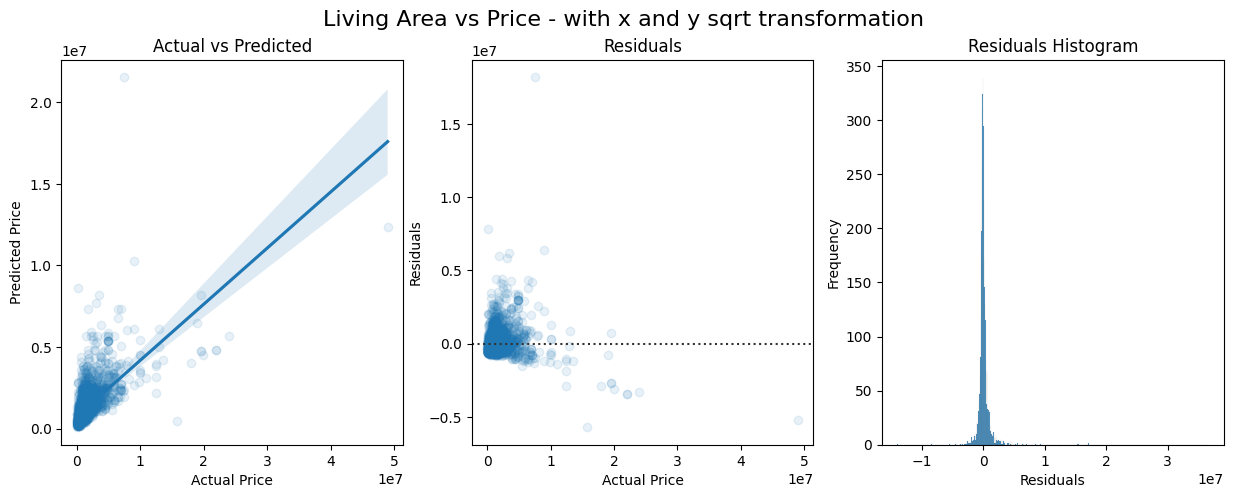

R2: 0.3983 - RMSE: 1333846.8700, MAE: 534759.8500



In [174]:
perform_linear_regression(X, y, np.sqrt, np.sqrt, True, "with x and y sqrt transformation")

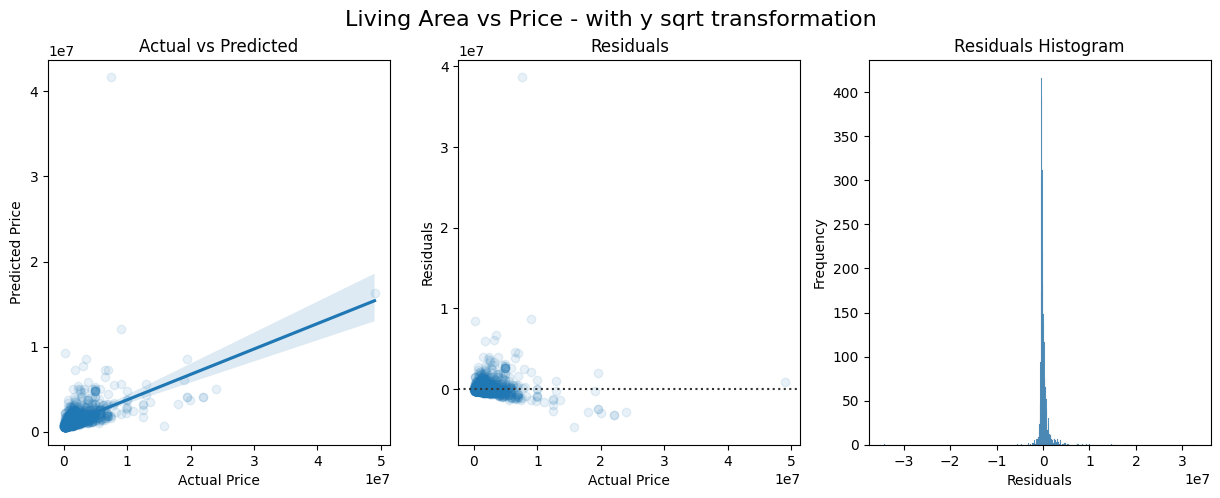

R2: 0.2886 - RMSE: 1450362.2100, MAE: 572916.3700



In [175]:
perform_linear_regression(X, y, None, np.sqrt, True, "with y sqrt transformation")

### Interpretation (2.1.1)

| Model | Transformation | R2 | MSE | RMSE | MAE |
| --- | --- | --- | --- | --- | --- |
| 2.1.1 | Baseline - keine Transformation | 0.3932 | 1794463645685.0149 | 1339575.9200| 570184.6900 |
| 2.1.1 | Log (x) | 0.3048 | 2055891258580.8923 | 1433837.9500 | 682242.5100 |
| 2.1.1 | Log (x and y) | 0.3744 | 1849995416173.8081 | 1360145.3700 | 524850.1700 |
| 2.1.1 | Log (y) | -479.3267 | 1420357861063845.0000 | 37687635.3900 | 1177128.4100 |
| 2.1.1 | Quadrat (x) | 0.0846 | 2707021454763.4038 | 1645302.8500 | 795996.3500 |
| 2.1.1 | Quadrat (x and y) | -0.0416 | 3079939207240.1196 | 1754975.5600 | 1246092.5000 |
| 2.1.1 | Quadratwurzel (x) | 0.3815 | 1829090981114.4050 | 1352438.9000 | 621362.0100 |
| 2.1.1 | Quadratwurzel (x and y) | 0.3983 | 1779147471555.6826 | 1333846.8700 | 534759.8500 |
| 2.1.1 | Quadratwurzel (y) | 0.2886 | 2103550544393.8164 | 1450362.2100 | 572916.3700 |

Das Modell mit Quadratwurzel (x und y) Transformation hat den höchsten R2-Wert (0.3983) und relativ niedrige Werte für MSE, RMSE und MAE. Dies deutet darauf hin, dass es unter den aufgeführten Modellen am besten die Variabilität der Daten erklärt und eine geringere Fehlerquote aufweist. Auf Basis dieser Analyse scheint es das beste unter den aufgelisteten zu sein.

## 2.1.2 Fehlende Werte bei `Floor_space_merged` ersetzen

Diese Übung ist offensichtlich (19'000+ NA Values) ein eher schlechter Ansatz, da wir hier die meisten Werte ersetzen bzw. mit Floor space füllen. Im Sinne der Experimente, führen wir das aber trotzdem druch.

In [176]:
# Replace missing 'Floor_space_merged' values with 'Living_area_unified' values
df_212['Floor_space_merged'] = df_212['Floor_space_merged'].fillna(df_212['Living_area_unified'])

# Subset dataset
df_212 = df_212[['Floor_space_merged', 'price_cleaned']]

# Drop na values
df_212 = df_212.dropna(subset=['Floor_space_merged'])

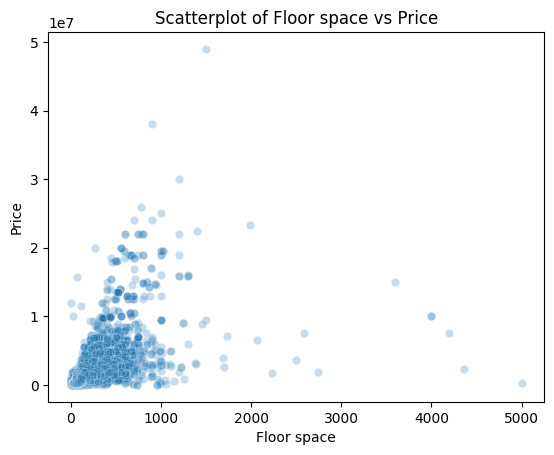

In [177]:
# Split dataset
X2 = df_212['Floor_space_merged']
y2 = df_212['price_cleaned']

sns.scatterplot(data=df_212, x=X2, y=y2, alpha=0.25)
plt.title('Scatterplot of Floor space vs Price')
plt.ylabel('Price')
plt.xlabel('Floor space')
plt.show()

In [178]:
perform_linear_regression(X2, y2, None, None, False, "Floor space vs Price - without transformation")

Floor space vs Price - without transformation
R2: 0.3499 - RMSE: 1489067.9300, MAE: 628984.7800



### Log-Transformation (2.1.2)

In [179]:
perform_linear_regression(X2, y2, np.log, np.log, False, "Floor space vs Price - with x and y log transformation")
perform_linear_regression(X2, y2, np.log, None, False, "Floor space vs Price - with x log transformation")
perform_linear_regression(X2, y2, None, np.log, False, "Floor space vs Price - with y log transformation")

Floor space vs Price - with x and y log transformation
R2: 0.3335 - RMSE: 1507824.1500, MAE: 582392.9500

Floor space vs Price - with x log transformation
R2: 0.2586 - RMSE: 1590283.6200, MAE: 729437.8800

Floor space vs Price - with y log transformation
R2: -10.4703 - RMSE: 6254956.2100, MAE: 757846.1800



### Quadrat-Transformation (2.1.2)

In [180]:
perform_linear_regression(X2, y2, np.square, None, False, "Floor space vs Price - with x squared transformation")
perform_linear_regression(X2, y2, np.square, np.square, False, "Floor space vs Price - with x and y squared transformation")

Floor space vs Price - with x squared transformation
R2: 0.0671 - RMSE: 1783866.5200, MAE: 836359.6400

Floor space vs Price - with x and y squared transformation
R2: -0.0179 - RMSE: 1863289.1400, MAE: 1264163.2400



### Quadratwurzel-Transformation (2.1.2)

In [181]:
perform_linear_regression(X2, y2, np.sqrt, np.sqrt, False, "Floor space vs Price - with x and y sqrt transformation")
perform_linear_regression(X2, y2, np.sqrt, None, False, "Floor space vs Price - with x sqrt transformation")
perform_linear_regression(X2, y2, None, np.sqrt, False, "Floor space vs Price - with y sqrt transformation")

Floor space vs Price - with x and y sqrt transformation
R2: 0.3555 - RMSE: 1482710.7800, MAE: 591063.3700

Floor space vs Price - with x sqrt transformation
R2: 0.3438 - RMSE: 1496045.9100, MAE: 666437.9100

Floor space vs Price - with y sqrt transformation
R2: 0.2881 - RMSE: 1558295.5300, MAE: 630991.2800



### Interpretation (2.1.2)

| Model | Transformation | R2 | RMSE | MAE |
| --- | --- | --- | --- | --- |
| 2.1.2 | Baseline - keine Transformation | 0.3499 | 1489067.9300 | 628984.7800 |
| 2.1.2 | Log (x und y) | 0.3335 | 1507824.1500 | 582392.9500 |
| 2.1.2 | Log (x) | 0.2586 | 1590283.6200 | 729437.8800 |
| 2.1.2 | Log (y) | -10.4703 | 6254956.2100 | 757846.1800 |
| 2.1.2 | Quadrat (x und y) | -0.0179 | 1863289.1400 | 1264163.2400 |
| 2.1.2 | Quadrat (x) | 0.0671 | 1783866.5200 | 836359.6400 |
| 2.1.2 | Quadratwurzel (x und y) | 0.3555 | 1482710.7800 | 591063.3700 |
| 2.1.2 | Quadratwurzel (x) | 0.3438 | 1496045.9100 | 666437.9100 |
| 2.1.2 | Quadratwurzel (y) | 0.2881 | 1558295.5300 | 630991.2800 |

Wie nach Erwartung sehen wir, dass die Modelle bei diesem Experiment nicht besser geworden sind.

## 2.1.3 Fehlende Werte bei `Living_area_unified` ersetzen

In [182]:
# Replace missing 'Living_area_unified' values with 'Floor_space_merged' values 
df_213['Living_area_unified'] = df_213['Living_area_unified'].fillna(df_213['Floor_space_merged'])

# Subset dataset
df_num212 = df_213[['Living_area_unified', 'price_cleaned']]

# Drop na values
df_num212 = df_213.dropna(subset=['Living_area_unified'])

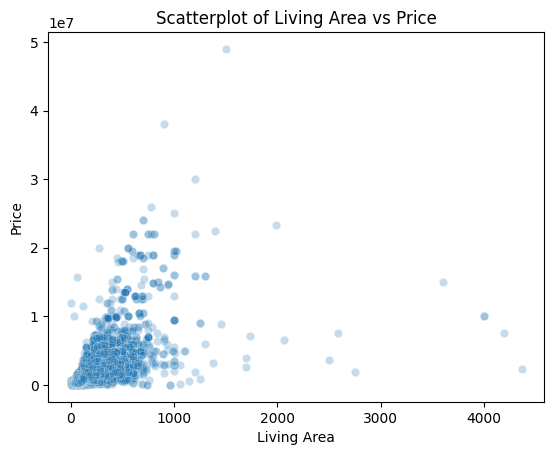

In [183]:
# Split dataset
X3 = df_213['Living_area_unified']
y3 = df_213['price_cleaned']

sns.scatterplot(data=df_213, x=X3, y=y3, alpha=0.25)
plt.title('Scatterplot of Living Area vs Price')
plt.ylabel('Price')
plt.xlabel('Living Area')
plt.show()

In [184]:
perform_linear_regression(X3, y3, None, None, False, "Living Area vs Price - without transformation")

Living Area vs Price - without transformation
R2: 0.3993 - RMSE: 1431370.0900, MAE: 604510.4100



### Log-Transformation (2.1.3)

In [185]:
perform_linear_regression(X3, y3, np.log, np.log, False, "Living Area vs Price - with x and y log transformation")
perform_linear_regression(X3, y3, np.log, None, False, "Living Area vs Price - with x log transformation")
perform_linear_regression(X3, y3, None, np.log, False, "Living Area vs Price - with y log transformation")

Living Area vs Price - with x and y log transformation
R2: 0.3879 - RMSE: 1444883.5700, MAE: 564085.7800

Living Area vs Price - with x log transformation
R2: 0.2802 - RMSE: 1566912.5400, MAE: 723867.9200

Living Area vs Price - with y log transformation
R2: -0.2018 - RMSE: 2024646.3900, MAE: 668169.3900



### Quadrat-Transformation (2.1.3)

In [186]:
perform_linear_regression(X3, y3, np.square, np.square, False, "Living Area vs Price - with x and y squared transformation")
perform_linear_regression(X3, y3, np.square, None, False, "Living Area vs Price - with x squared transformation")

Living Area vs Price - with x and y squared transformation
R2: 0.0196 - RMSE: 1828643.6700, MAE: 1243486.6600

Living Area vs Price - with x squared transformation
R2: 0.0884 - RMSE: 1763361.1100, MAE: 828685.3900



### Quadratwurzel-Transformation (2.1.3)

In [187]:
perform_linear_regression(X3, y3, np.sqrt, np.sqrt, False, "Living Area vs Price - with x and y sqrt transformation")
perform_linear_regression(X3, y3, np.sqrt, None, False, "Living Area vs Price - with x sqrt transformation")
perform_linear_regression(X3, y3, None, np.sqrt, False, "Living Area vs Price - with y sqrt transformation")

Living Area vs Price - with x and y sqrt transformation
R2: 0.4078 - RMSE: 1421277.5000, MAE: 572081.8300

Living Area vs Price - with x sqrt transformation
R2: 0.3753 - RMSE: 1459762.2900, MAE: 659822.3600

Living Area vs Price - with y sqrt transformation
R2: 0.3761 - RMSE: 1458847.0100, MAE: 605729.8900



### Interpretation (2.1.3)

| Model | Transformation | R2 | RMSE | MAE |
| --- | --- | --- | --- | --- |
| 2.1.3 | Baseline - Keine Transformation | 0.3993 | 1431370.0900 | 604510.4100 |
| 2.1.3 | Log (x und y ) | 0.3879 | 1444883.5700 | 564085.7800 |
| 2.1.3 | Log (x) | 0.2802 | 1566912.5400 | 723867.9200 |
| 2.1.3 | Log (y) | -0.2018 | 2024646.3900 | 668169.3900 |
| 2.1.3 | Quadrat (x und y)| 0.0196 | 1828643.6700 | 1243486.6600 |
| 2.1.3 | Quadrat (x)| 0.0884 | 1763361.1100 | 828685.3900 |
| 2.1.3 | Quadratwurzel (x und y) | 0.4078 | 1421277.5000 | 572081.8300 |
| 2.1.3 | Quadratwurzel (x)| 0.3753 | 1459762.2900 | 659822.3600 |
| 2.1.3 | Quadratwurzel (y) | 0.3761 | 1458847.0100 | 605729.8900 |

Diese Tabelle zeigt, wie verschiedene Transformationen die Vorhersagegenauigkeit der Beziehung zwischen Wohnfläche und Preis beeinflussen. Das Modell mit der höchsten R2-Wert und niedrigsten Fehlerwerten (RMSE, MAE) scheint das beste zu sein. In diesem Fall ist das Modell mit der Quadratwurzel-Transformation von x und y (R2: 0.4078) am effektivsten.

Wir sehen eine Verbesserung der Modelle, wenn wir die fehlenden Werte von `Living_area_unified` mit `Floor_space_merged` ersetzen.

## 2.1.4 Feature Engineering

In diesem Abschnitt versuchen wir anhand der beiden Features `Floor_space_merged` und `Living_area_unified` ein neues Feature zu generieren, das anstelle `Floor_space_merged` verwendet wird.

In [188]:
# Make df_num214['calc'] whatever value is bigger of df_num214['Living_area_unified'] or df_num214['Floor_space_merged']
df_214['calc'] = df_214[['Living_area_unified', 'Floor_space_merged']].max(axis=1)

# Subset dataset
df_214 = df_214[['calc', 'price_cleaned']]

# Drop na values
df_214 = df_214.dropna(subset=['calc'])

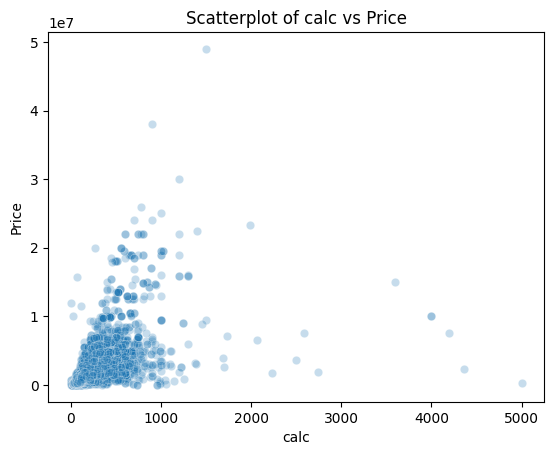

In [189]:
# Split dataset
X4 = df_214['calc']
y4 = df_214['price_cleaned']

sns.scatterplot(data=df_214, x=X4, y=y4, alpha=0.25)
plt.title('Scatterplot of calc vs Price')
plt.ylabel('Price')
plt.xlabel('calc')
plt.show()

In [190]:
perform_linear_regression(X4, y4, None, None, False, "calc vs Price - without transformation")

calc vs Price - without transformation
R2: 0.3505 - RMSE: 1488378.7900, MAE: 625766.4800



### Log-Transformation (2.1.4)

In [191]:
perform_linear_regression(X4, y4, np.log, np.log, False, "calc vs Price - with x and y log transformation")
perform_linear_regression(X4, y4, np.log, None, False, "calc vs Price - with x log transformation")
perform_linear_regression(X4, y4, None, np.log, False, "calc vs Price - with y log transformation")

calc vs Price - with x and y log transformation
R2: 0.3413 - RMSE: 1498902.2600, MAE: 579782.0100

calc vs Price - with x log transformation
R2: 0.2686 - RMSE: 1579489.7500, MAE: 724371.6400

calc vs Price - with y log transformation
R2: -10.9442 - RMSE: 6382884.6900, MAE: 759422.7000



### Quadrat-Transformation (2.1.4)

In [192]:
perform_linear_regression(X4, y4, np.square, None, False, "calc vs Price - with x squared transformation")
perform_linear_regression(X4, y4, np.square, np.square, False, "calc vs Price - with x and y squared transformation")

calc vs Price - with x squared transformation
R2: 0.0671 - RMSE: 1783855.6000, MAE: 836263.0600

calc vs Price - with x and y squared transformation
R2: -0.0178 - RMSE: 1863224.5400, MAE: 1264137.8100



### Quadratwurzel-Transformation (2.1.4)

In [193]:
perform_linear_regression(X4, y4, np.sqrt, np.sqrt, False, "calc vs Price - with x and y sqrt transformation")
perform_linear_regression(X4, y4, np.sqrt, None, False, "calc vs Price - with x sqrt transformation")
perform_linear_regression(X4, y4, None, np.sqrt, False, "calc vs Price - with y sqrt transformation")

calc vs Price - with x and y sqrt transformation
R2: 0.3568 - RMSE: 1481192.8000, MAE: 587623.4900

calc vs Price - with x sqrt transformation
R2: 0.3470 - RMSE: 1492399.4000, MAE: 661346.8500

calc vs Price - with y sqrt transformation
R2: 0.2881 - RMSE: 1558233.6700, MAE: 629332.8200



### Interpretation (2.1.4)

| Model | Transformation | R2 | RMSE | MAE |
| --- | --- | --- | --- | --- |
| 2.1.4 | Baseline - keine Transformation | 0.3505 | 1488378.7900 | 625766.4800 |
| 2.1.4 | Log (x und y) | 0.3413 | 1498902.2600 | 579782.0100 |
| 2.1.4 | Log (x) | 0.2686 | 1579489.7500 | 724371.6400 |
| 2.1.4 | Log (y) | -10.9442 | 6382884.6900 | 759422.7000 |
| 2.1.4 | Quadrat (x) | 0.0671 | 1783855.6000 | 836263.0600 |
| 2.1.4 | Quadrat (x und y) | -0.0178 | 1863224.5400 | 1264137.8100 |
| 2.1.4 | Quadratwurzel (x und y) | 0.3568 | 21481192.8000 | 587623.4900 |
| 2.1.4 | Quadratwurzel (x) | 0.3470 | 1492399.4000 | 661346.8500 |
| 2.1.4 | Quadratwurzel (y) | 0.2881 | 1558233.6700 | 629332.8200 |

Diese Tabelle zeigt die Ergebnisse verschiedener Transformationen für das Modell 2.1.4 in Bezug auf die Beziehung zwischen der neu generierten Variable `calc` und `price_cleaned`. Basierend auf den R2-Werten und den Fehlermetriken (RMSE, MAE) scheint das Modell mit der Quadratwurzel-Transformation von x und y (R2: 0.3568) am besten abzuschneiden. Aber nicht besser als das Modell aus 2.1.3.

Hier nochmals das beste Modell 2.1.3 - fehlende Werte von `Living_area_unified` mit `Floor_space_merged` ersetzt):
- Quadratwurzel (x und y) 
- $R^2$: 0.4078 

## Outlier Handling

In [194]:
def perform_linear_regression_r2(X, y, x_transformation_func=None, y_transformation_func=None):
    """
    Performs linear regression on the provided dataset and returns the R2 score.
    """

    # Apply transformation if provided
    if x_transformation_func:
        X = x_transformation_func(X)

    if y_transformation_func:
        y = y_transformation_func(y)
    
    # Split dataset
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Train linear regression model
    lin_reg = LinearRegression()

    if len(X_train.shape) == 1:
        lin_reg.fit(X_train.values.reshape(-1, 1), y_train)
        y_pred = lin_reg.predict(X_test.values.reshape(-1, 1))
    else:
        lin_reg.fit(X_train, y_train)
        y_pred = lin_reg.predict(X_test)

    # Transform back to original scale
    if y_transformation_func and y_transformation_func.__name__ == 'log':
        y_pred = np.exp(y_pred)
        y_test = np.exp(y_test)
    elif y_transformation_func and y_transformation_func.__name__ == 'sqrt':
        y_pred = np.square(y_pred)
        y_test = np.square(y_test)
    elif y_transformation_func and y_transformation_func.__name__ == 'square':
        y_pred = np.sqrt(y_pred)
        y_test = np.sqrt(y_test)

    r2 = round(r2_score(y_test, y_pred),4)
    
    return r2

### IQR

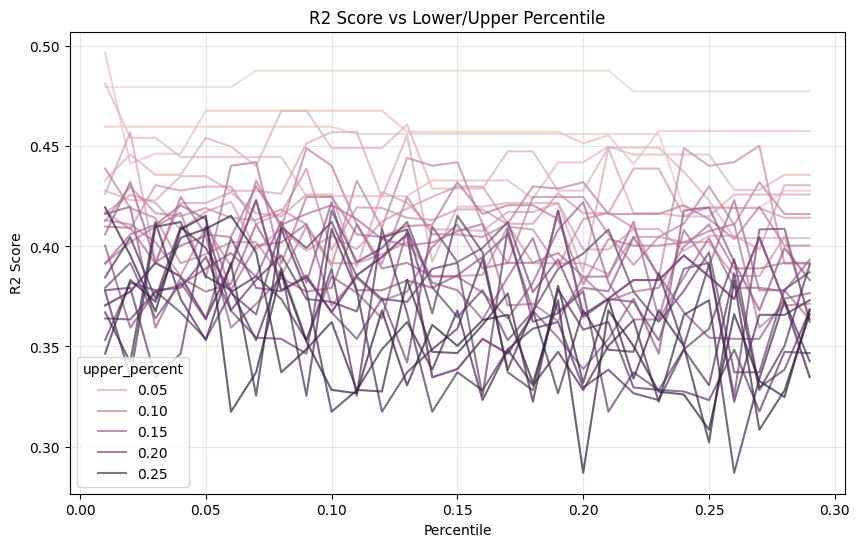

Best R2 Score:
   lower_percent  upper_percent  R2 Score  Amount of Entries
2           0.01           0.03    0.4968              20722


In [195]:
threshold_range = np.arange(1, 30, 1) / 100
results = []

# Iterate over all combinations of lower and upper percentiles
for lower_percent, upper_percent in itertools.product(threshold_range, threshold_range):
    Q1 = df_213['Living_area_unified'].quantile(lower_percent)
    Q3 = df_213['Living_area_unified'].quantile(1 - upper_percent)
    IQR = Q3 - Q1

    Lower_Whisker = Q1 - 1.5 * IQR
    Upper_Whisker = Q3 + 1.5 * IQR

    Q12 = df_213['price_cleaned'].quantile(lower_percent)
    Q32 = df_213['price_cleaned'].quantile(1 - upper_percent)
    IQR2 = Q32 - Q12

    Lower_Whisker2 = Q12 - 1.5 * IQR2
    Upper_Whisker2 = Q32 + 1.5 * IQR2

    df_num2133 = df_213[(df_213['Living_area_unified'] > Lower_Whisker) & (df_213['Living_area_unified'] < Upper_Whisker)]
    X33 = df_num2133['Living_area_unified']
    y33 = df_num2133['price_cleaned']

    # Calculate R2 score
    r2 = perform_linear_regression_r2(X33, y33, np.sqrt, np.sqrt)

    results.append({'lower_percent': lower_percent, 'upper_percent': upper_percent, 'R2 Score': r2, 'Amount of Entries': df_num2133.shape[0]})

# Create a DataFrame from the results list
r2_scores = pd.DataFrame(results)

# Plot the results
plt.figure(figsize=(10, 6))
sns.lineplot(data=r2_scores, x='lower_percent', y='R2 Score', hue='upper_percent', alpha=0.7)
plt.title('R2 Score vs Lower/Upper Percentile')
plt.ylabel('R2 Score')
plt.xlabel('Percentile')
plt.grid(True, alpha=0.3)
plt.show()

# Print the best R2 score
best_r2 = r2_scores.sort_values(by='R2 Score', ascending=False).head(1)
print("Best R2 Score:")
print(best_r2)


### Z-Score

In [196]:
r2_scores = []
threshold_range = np.arange(0.5, 50, 0.5)

In [197]:
for threshold in threshold_range:
    df_temp = df_213.copy()
    z = np.abs(stats.zscore(df_temp['Living_area_unified']))
    df_temp = df_temp[(z < threshold)]
    X34 = df_temp['Living_area_unified']
    y34 = df_temp['price_cleaned']
    r2 = perform_linear_regression_r2(X34, y34, None, None)
    r2_scores.append(r2)

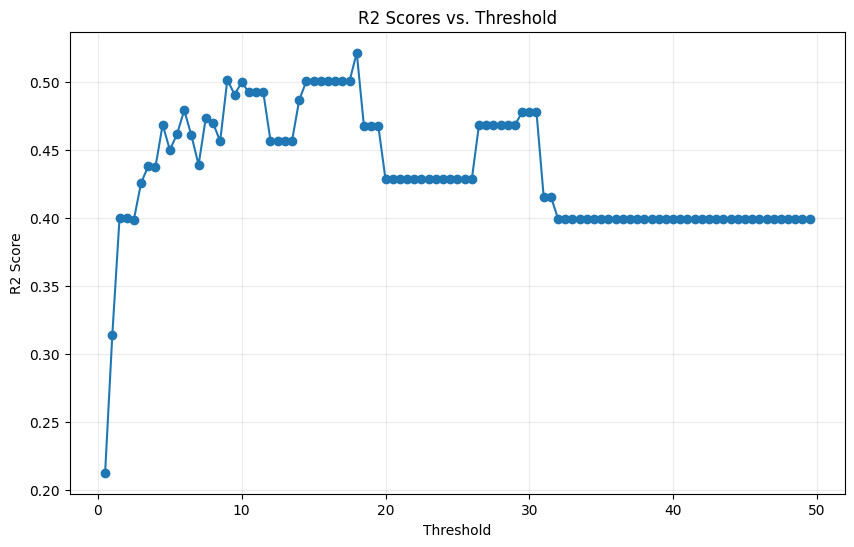

Max R2 Score: 0.5213


In [198]:
plt.figure(figsize=(10, 6))
plt.plot(threshold_range, r2_scores, marker='o', linestyle='-')
plt.title('R2 Scores vs. Threshold')
plt.xlabel('Threshold')
plt.ylabel('R2 Score')
plt.grid(True, alpha=0.25)
plt.show()
print('Max R2 Score:', np.max(r2_scores))

In [199]:
# get index of max r2 score
max_r2_index = np.argmax(r2_scores)
print('Index of Max R2 Score:', max_r2_index/2+0.5)

Index of Max R2 Score: 18.0


In [200]:
threshold = max_r2_index/2+0.5
df_temp = df_213.copy()
z = np.abs(stats.zscore(df_temp['Living_area_unified']))
df_temp = df_temp[(z < threshold)]
X34 = df_temp['Living_area_unified']
y34 = df_temp['price_cleaned']
print(df_temp.shape)

(20748, 57)


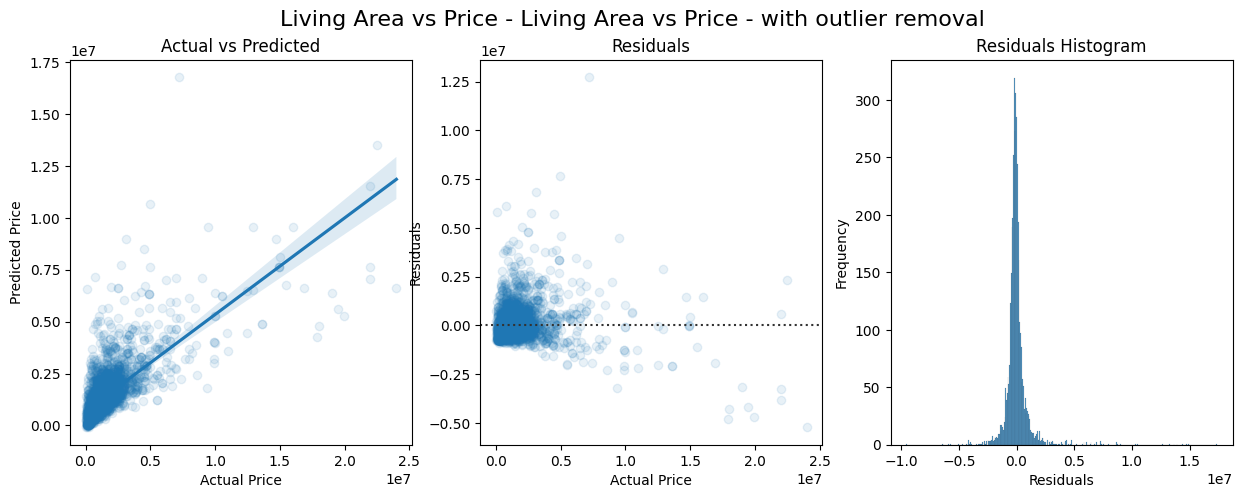

R2: 0.5213 - RMSE: 1179279.2600, MAE: 555138.4500



In [201]:
perform_linear_regression(X34, y34, None, None, True, "Living Area vs Price - with outlier removal")

In [202]:
perform_linear_regression(X34, y34, np.log, np.log, False, "Living Area vs Price - with x and y log transformation")
perform_linear_regression(X34, y34, np.log, None, False, "Living Area vs Price - with x log transformation")
perform_linear_regression(X34, y34, None, np.log, False, "Living Area vs Price - with y log transformation")

Living Area vs Price - with x and y log transformation
R2: 0.4524 - RMSE: 1261284.2300, MAE: 532575.2900

Living Area vs Price - with x log transformation
R2: 0.3645 - RMSE: 1358776.6400, MAE: 682822.6500

Living Area vs Price - with y log transformation
R2: -48.1833 - RMSE: 11953164.0100, MAE: 819575.6700



In [203]:
perform_linear_regression(X34, y34, np.square, None, False, "Living Area vs Price - with x square transformation")

Living Area vs Price - with x square transformation
R2: 0.3696 - RMSE: 1353304.4900, MAE: 689117.5000



In [204]:
perform_linear_regression(X34, y34, np.sqrt, np.sqrt, False, "Living Area vs Price - with x and y sqrt transformation")
perform_linear_regression(X34, y34, np.sqrt, None, False, "Living Area vs Price - with x sqrt transformation")
perform_linear_regression(X34, y34, None, np.sqrt, False, "Living Area vs Price - with y sqrt transformation")

Living Area vs Price - with x and y sqrt transformation
R2: 0.4967 - RMSE: 1209228.2400, MAE: 534978.3400

Living Area vs Price - with x sqrt transformation
R2: 0.4664 - RMSE: 1244981.0500, MAE: 628538.0900

Living Area vs Price - with y sqrt transformation
R2: 0.4742 - RMSE: 1235869.9100, MAE: 547842.4100



In [205]:
model = train_linear_regression(X34, y34, np.sqrt, np.sqrt)
filename = '../../99_gespeicherte_modelle/linreg_model.sav'
pickle.dump(model, open(filename, 'wb'))

## Interpretation

In [206]:
median = df_213['price_cleaned'].median()
print('Median:', median)

Median: 865000.0


Ein R2 von 0.52 ist das beste, was wir hier erzielen können. Die Residiuen zeigen weiterhin, dass das Modell zu wenig komplex ist. Wir haben aber immer noch einen Mean-Average-Error von ca. CHF 555'000 auf den tatsächlichen Preis. Bei einer durchschnittlichen Preis der Immobilien von CHF 865'000 ist das ein miserables Resultat.

Wir sind deshalb auf andere Modelle angewiesen und können uns nicht auf eine einfache Lineare Regression verlassen.